In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv
/kaggle/input/rsna-breast-cancer-detection/train.csv
/kaggle/input/rsna-breast-cancer-detection/test.csv
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/937109986.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/34700621.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/1167990339.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/1291014447.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/831671840.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/1481837831.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/851000290.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/34867/1724313070.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/34867/1816992952.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/34867/1416

In [2]:
# connectome will be installed automatically, because `amid` depends on it

!pip install amid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 579.0 kB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.6/269.6 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.6/237.6 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 38.8 MB/s e

# Converting image background white to black

In [29]:
from amid.rsna_bc import RSNABreastCancer

ds = RSNABreastCancer('/kaggle/input/rsna-breast-cancer-detection/')
train = pd.read_csv("../input/rsna-breast-cancer-detection/train.csv")


In [4]:
dir(ds)

['BIRADS',
 'age',
 'biopsy',
 'cancer',
 'density',
 'difficult_negative_case',
 'id',
 'ids',
 'image',
 'image_id',
 'implant',
 'intensity_sign',
 'invasive',
 'laterality',
 'machine_id',
 'padding_value',
 'patient_id',
 'prediction_id',
 'site_id',
 'view']

In [5]:
len(ds.ids)

54710

In [6]:
i = ds.ids[0]
i

'1000030932'

In [7]:
ds.age(i), ds.implant(i), ds.cancer(i), ds.view(i)

(69.0, False, False, 'CC')

In [8]:
import matplotlib.pyplot as plt

def show(x):
    plt.imshow(x, cmap='gray')

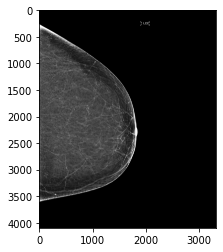

In [9]:
show(ds.image(i))

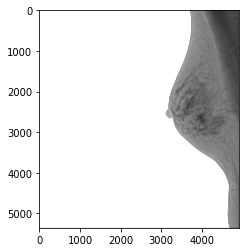

In [10]:
i2 = '2028281852'
show(ds.image(i2))

In [11]:
from connectome import Transform


class Normalize(Transform):
    """
    Inverts the image intensity if necessary, so that the background is always zero
    """

    __inherit__ = True # inherit all fields from the previous layer

    def image(image, padding_value, intensity_sign):
        if padding_value is not None:
            if padding_value > 0:
                return padding_value - image
            return image
        
        # if no padding value is available, we can conpute it ourselves
        if intensity_sign == 1:
            return image.max() - image

        return image

In [12]:
dataset = ds >> Normalize()

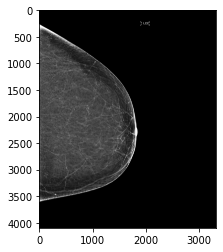

In [13]:
# nothing changed here, the bg was already black
show(dataset.image(i))

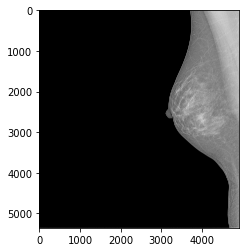

In [14]:
# but this one got normalized
show(dataset.image(i2))

# Crop the background

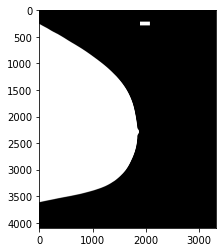

In [15]:
show(dataset.image(i) > 0)

In [16]:
class CropBackground(Transform):
    __inherit__ = True
    
    def image(image):
        mask = image > 0
        xs, = mask.any(0).nonzero()
        ys, = mask.any(1).nonzero()
        return image[ys.min():ys.max() + 1, xs.min():xs.max() + 1]

In [17]:
from connectome import Chain


# Chain(a, b, c) is a more convenient way to write a >> b >> c
dataset = Chain(
    ds,
    Normalize(),
    CropBackground(),
)

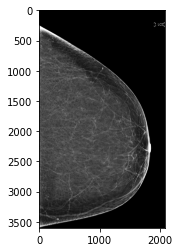

In [18]:
show(dataset.image(i))

# Remove the label

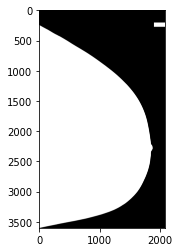

In [19]:
show(dataset.image(i) > 0)

In [20]:
from skimage.morphology import label
import numpy as np


class GetGreatestComponent(Transform):
    __inherit__ = True
    
    def image(image):
        # find all the connected components
        lbl = label(image > 0)
        # caclulate their sizes
        values, counts = np.unique(lbl, return_counts=True)
        # 0 is always the background - we don't need it
        foreground = values != 0
        component = values[foreground][counts[foreground].argmax()]
        # select all the components greater than the background
        #  + the greatest foreground component
        components = set(values[counts > counts[~foreground]]) | {component}
        if len(components) > 1:
            # if there are several components - pick the one with the greatest intensity
            component = max(components, key=lambda c: image[lbl == c].mean())

        return image * (lbl == component)

In [21]:
dataset = Chain(
    ds,
    Normalize(),
    GetGreatestComponent(),
    CropBackground(),
)

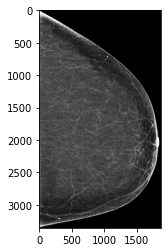

In [22]:
show(dataset.image(i))

# Noice remove

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from cv2 import resize
from numpy import amax, uint8
from pathlib import Path
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import apply_voi_lut as avl
from skimage import exposure as ex
from collections import defaultdict




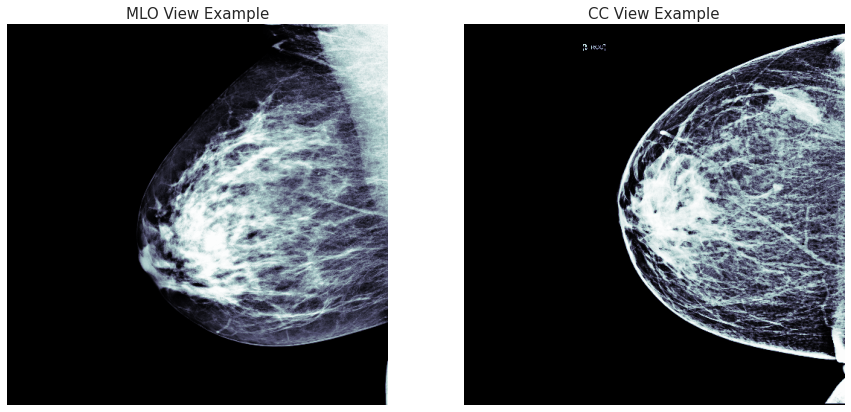

In [48]:
def get_dicom(patient_id, img_id):
    return dcmread(Path(DICOM_PATH_SPEC.format(DATASET_PATH, DATASET_TYPE, patient_id, img_id)))

def get_data(dcm):
    d = avl(dcm.pixel_array, dcm)
    d = amax(d) - d if dcm.get(PHOTO_INT) == MONO else d
    return (d * (255.0 / d.max())).astype(uint8)

def normalize_image(img):
    img = ex.equalize_hist(img) if NORM_TYPE == "histogram" else ex.equalize_adapthist(img/np.max(img))
    return (img * 255).astype(uint8)
    
def resize_image(img, width, height):
    return resize(img, (width, height))

def extract(patient_id, img_id):
    img = get_data(get_dicom(patient_id, img_id))
    height, width = img.shape
    if DO_NORMALIZE:
        img = normalize_image(resize_image(img, RESCALE_WIDTH, RESCALE_HEIGHT))
    return [img_id, width, height, img]

mlo_ex = train[
    (train["age"] > 50.0) & 
    (train["age"] < 55.0) & 
    (train["view"] == "MLO") & 
    (train["laterality"] == "R") &
    (train["cancer"] == 0)
].iloc[[0]]
mlo_ex_img = extract(mlo_ex["patient_id"].iloc[0], mlo_ex["image_id"].iloc[0])

cc_ex = train[
    (train["cancer"] == 1) & 
    (train["age"] > 50.0) & 
    (train["age"] < 55.0) & 
    (train["view"] == "CC") & 
    (train["laterality"] == "R")
].iloc[[2]]
cc_ex_img = extract(cc_ex["patient_id"].iloc[0], cc_ex["image_id"].iloc[0])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.set_style('darkgrid')
sns.set_palette('Set2')

_ = axs[0].imshow(mlo_ex_img[3], cmap="bone")
_ = axs[0].axis("off")
_ = axs[0].set_title("MLO View Example", fontsize=15)
_ = axs[1].imshow(cc_ex_img[3], cmap="bone")
_ = axs[1].axis("off")
_ = axs[1].set_title("CC View Example", fontsize=15)

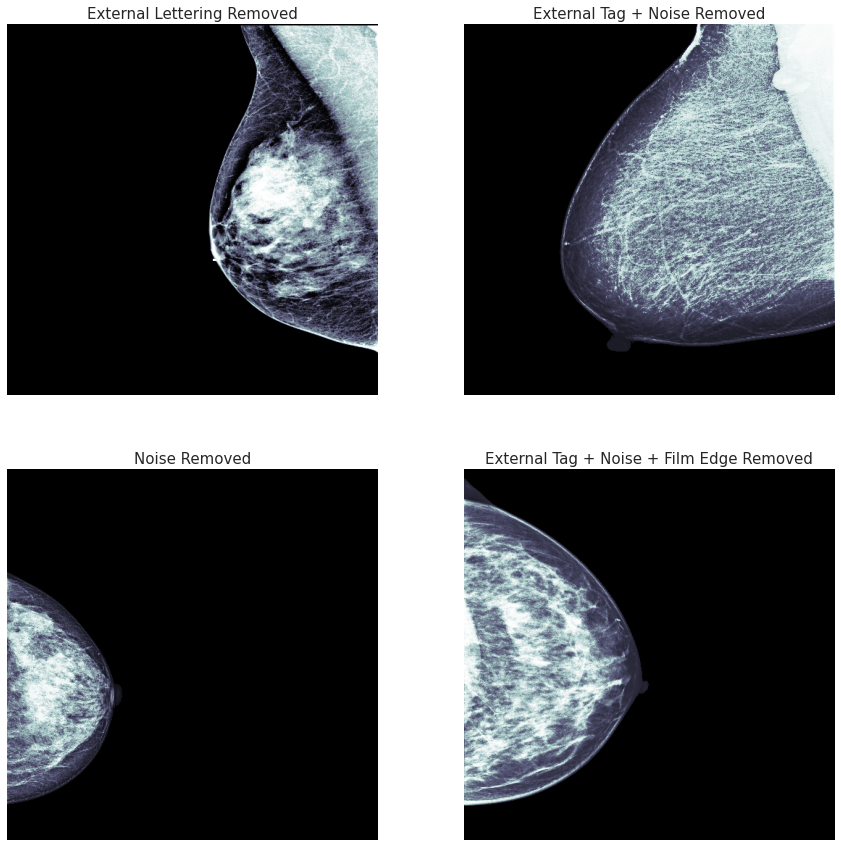

In [49]:
import cv2

def true_norm(img):
    norm = (img - np.min(img))
    norm = (norm / np.max(norm)) * 255
    return norm.astype(np.uint8)

def mask_external_contour(pixels):
    contours, _ = cv2.findContours(pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(pixels.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    return cv2.bitwise_and(pixels, mask)

def get_clean_image(patient_id, image_id):
    return mask_external_contour(true_norm(extract(patient_id, image_id)[3]))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

RESCALE_WIDTH = 512
RESCALE_HEIGHT = 512 

_ = axs[0].imshow(get_clean_image(58637, 3343518), cmap="bone")
_ = axs[0].axis("off")
_ = axs[0].set_title("External Lettering Removed", fontsize=15)
_ = axs[1].imshow(get_clean_image(37851, 1494143), cmap="bone")
_ = axs[1].axis("off")
_ = axs[1].set_title("External Tag + Noise Removed", fontsize=15)
_ = axs[2].imshow(get_clean_image(29941, 4830494), cmap="bone")
_ = axs[2].axis("off")
_ = axs[2].set_title("Noise Removed", fontsize=15)
_ = axs[3].imshow(get_clean_image(14995, 8964180), cmap="bone")
_ = axs[3].axis("off")
_ = axs[3].set_title("External Tag + Noise + Film Edge Removed", fontsize=15)

# Left to Right Orientation

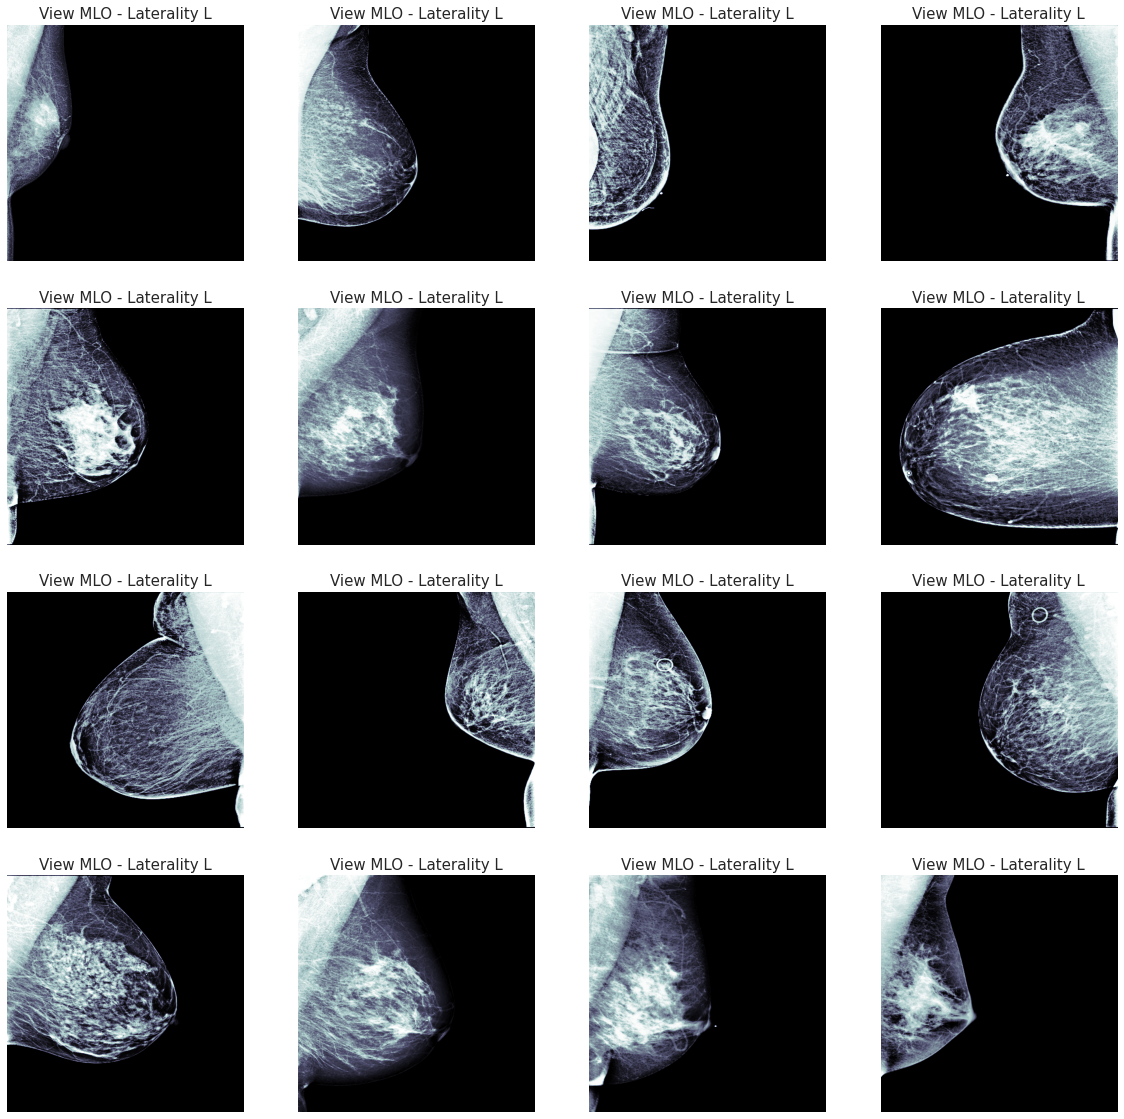

In [59]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

count = 0
skip_count = 100
skip = False

for index, row in train[(train["laterality"] == "L") & (train["view"] == "MLO")].iterrows():
    if skip == 0:
        skip = 100
        _ = axs[count].imshow(get_clean_image(row["patient_id"], row["image_id"]), cmap="bone")
        _ = axs[count].axis("off")
        _ = axs[count].set_title("View {} - Laterality {}".format(row["view"], row["laterality"]), fontsize=15)
        count += 1
        if count > 15:
            break
    else:
        skip -= 1

We can see that although we are looking at a laterality of L with the view of MLO, we have imaging that has the chest wall on both the right and left hand side of the image. While we could normalize each L and R to their respective sides, it would be more worthwhile to orient all of the images the same way. The reasoning for this step is that we probably want to start creating a standard / normalized view of each image. To do that, we'll orient our images such that the chest wall will be on the left hand side of the image.

A simple method to ensure each image is oriented the way we want is simply to find the center line in our existing image, and use Python's Numpy to slice the image array in half. Then, we'll mask out each pixel such that it is zero or one (on or off), and then sum the arrays. If the right hand array has more pixels on when compared to the left, then we use OpenCV to flip the image. Here is how the images above look when we apply this method.

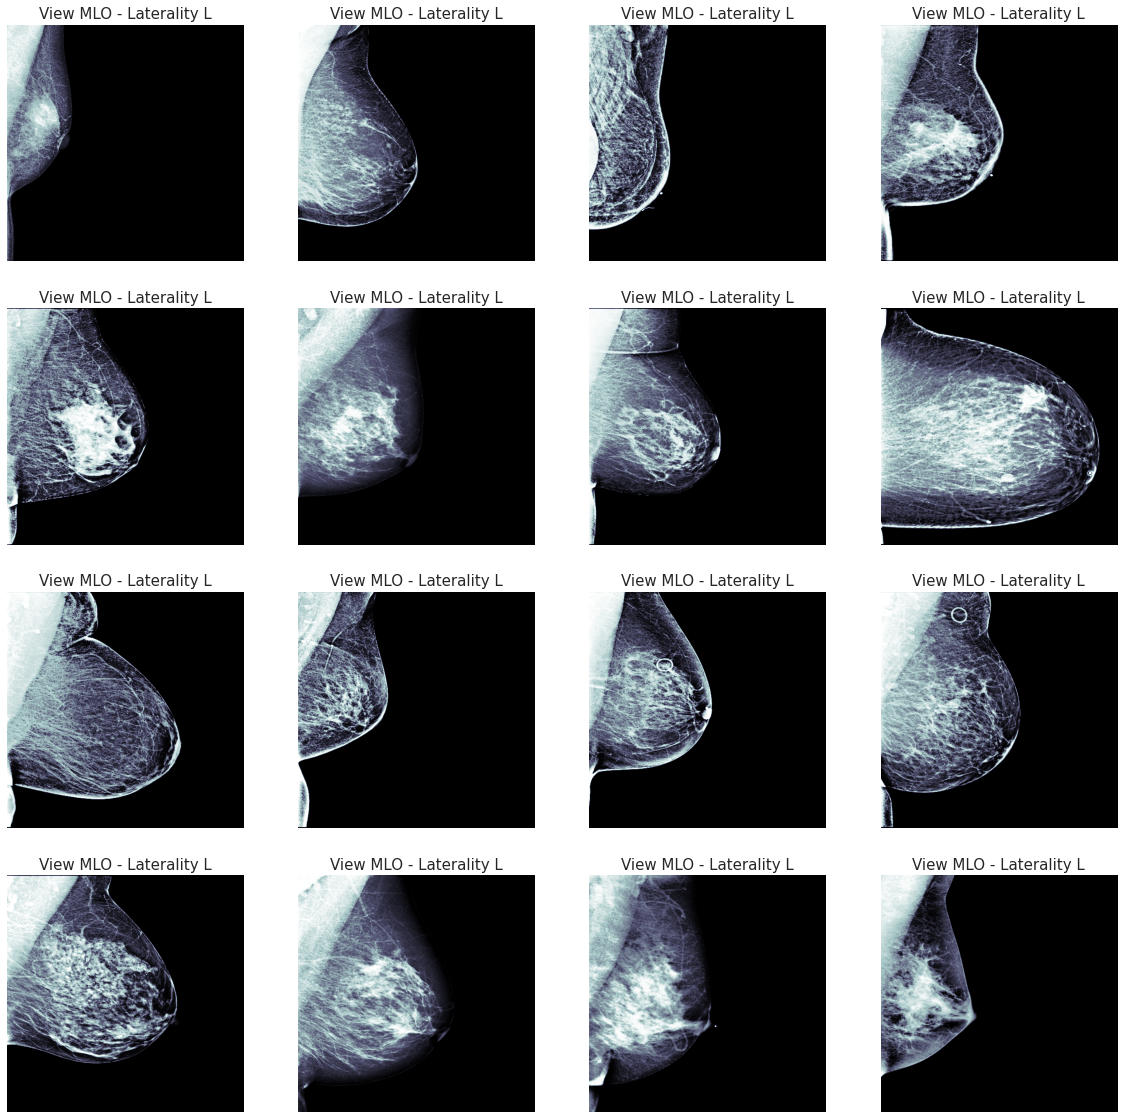

In [58]:
def slice_image(img):
    _, width = img.shape
    new_width = int(width / 2)
    left_img = img[:, 0:new_width]
    right_img = img[:, new_width:]
    return left_img, right_img

def mask_pixels(img):
    img[img > 1] = 1
    return img

def count_pixels(img):
    return np.sum(img)

def normalize_horiz_orientation(img):
    left_img, right_img = slice_image(mask_pixels(img.copy()))
    if count_pixels(right_img) > count_pixels(left_img):
        return cv2.flip(img, 1)
    return img

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

count = 0
skip_count = 100
skip = False

for index, row in train[(train["laterality"] == "L") & (train["view"] == "MLO")].iterrows():
    if skip == 0:
        skip = 100
        _ = axs[count].imshow(normalize_horiz_orientation(get_clean_image(row["patient_id"], row["image_id"])), cmap="bone")
        _ = axs[count].axis("off")
        _ = axs[count].set_title("View {} - Laterality {}".format(row["view"], row["laterality"]), fontsize=15)
        count += 1
        if count > 15:
            break
    else:
        skip -= 1